# Imports

In [1]:
# Append location to path to allow custom modules to be used.
import sys, os
sys.path.append(os.path.abspath(".."))

In [2]:
import cgael
from cgael.models.SimpleColor import *

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layer

import pygad
import pygad.kerasga

import numpy as np
import pandas as pd

# Set Up

In [26]:
output_folder = os.path.join("..", "results","single_simple_color")

In [23]:
experiment_name = "temp"

# Training

In [3]:
ts = cgael.LanguageTokenSet("CHAT", '-')
gen = SimpleColorGenerator([Swatch.WHITE, Swatch.BLACK], blur=0, batch_lock=True)
model = SimpleColorModel(token_set=ts, word_count=1, word_length=3)

In [4]:
ga_inst = model.train(
    generator = gen,
    generations = 1,
    num_solutions = 50,
    num_parents_mating = 10,
)

c:\Users\nicho\PyProjects\CGAEL\.conda\Lib\site-packages\pygad\pygad.py:909: UserWarning: The steady-state parent (sss) selection operator is used despite that no parents are kept in the next generation.
  warnings.warn("The steady-state parent (sss) selection operator is used despite that no parents are kept in the next generation.")


Completed Generation: 1
Generating new batch...
Identifying best...


In [27]:
np.save(os.path.join(output_folder, f"{experiment_name}.npy"), np.array(model.model.get_weights(), dtype="object"))

# Evaluation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


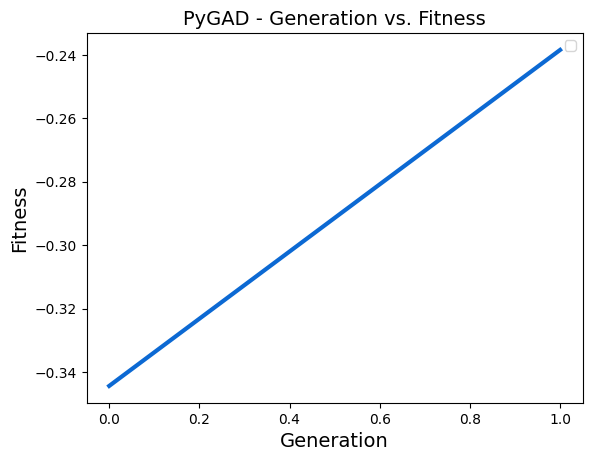

In [10]:
plot = ga_inst.plot_fitness(title=experiment_name, color="#0C69D3")

In [5]:
KEY_SWATCH = "swatch"
KEY_TEXT = "text"
KEY_IN = "input"
KEY_OUT = "output"
KEY_ROUND = "output_rounded"

swatches = [Swatch.BLACK, Swatch.RED, Swatch.GREEN, Swatch.YELLOW, Swatch.BLUE, Swatch.MAGENTA, Swatch.CYAN, Swatch.WHITE]
samples = np.array([[sample_swatch(x)] for x in swatches])
lang, out = model.model(samples)
text = [ts.decode(x) for x in lang]

d = {x:[] for x in [KEY_SWATCH, KEY_TEXT, KEY_IN, KEY_OUT, KEY_ROUND]}
for s, t, i, o in zip(swatches, text, samples, out):
    d[KEY_SWATCH].append(s)
    d[KEY_TEXT].append(t)
    d[KEY_IN].append(i)
    o = o.numpy()
    d[KEY_OUT].append(o)
    o = np.round(o)
    d[KEY_ROUND].append(o)
df = pd.DataFrame(data=d)
display(df)

,swatch,text,input,output,output_rounded
0,Swatch.BLACK,HTA,"[[0.0, 0.0, 0.0]]","[[0.041582324, 0.14524993, 0.05998267]]","[[0.0, 0.0, 0.0]]"
1,Swatch.RED,HCT,"[[0.0, 0.0, 1.0]]","[[0.4682522, 0.21133715, 0.25468653]]","[[0.0, 0.0, 0.0]]"
2,Swatch.GREEN,HTT,"[[0.0, 1.0, 0.0]]","[[0.6465994, 0.02130992, 0.19727664]]","[[1.0, 0.0, 0.0]]"
3,Swatch.YELLOW,HCT,"[[0.0, 1.0, 1.0]]","[[0.4682522, 0.21133715, 0.25468653]]","[[0.0, 0.0, 0.0]]"
4,Swatch.BLUE,HTA,"[[1.0, 0.0, 0.0]]","[[0.041582324, 0.14524993, 0.05998267]]","[[0.0, 0.0, 0.0]]"
5,Swatch.MAGENTA,HAA,"[[1.0, 0.0, 1.0]]","[[0.41592762, 0.8713109, 0.2780331]]","[[0.0, 1.0, 0.0]]"
6,Swatch.CYAN,HT,"[[1.0, 1.0, 0.0]]","[[0.07495147, 0.10580647, 0.10722944]]","[[0.0, 0.0, 0.0]]"
7,Swatch.WHITE,HA,"[[1.0, 1.0, 1.0]]","[[0.5707936, 0.8250065, 0.42024803]]","[[1.0, 1.0, 0.0]]"
